In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

data = pd.read_excel('EPOC dataset.xlsx')

columns = ['metal','support','wt.%','ionic species','particle size(nm)','metal loading (mg)','CO2:H2 ratio','temp(℃)','rCO(mol/s)',
          'voltage(V)','ρCO','ΛCO']
data = data[columns]

# change string in data['metal'] into int with metal's atomic mass
data['metal'] = data['metal'].replace(['Fe','Co','Ni','Cu','ZnO','Ru','Rh','Pd','Pt'],
                                      ['55.8','58.9','58.7','63.5','65.4','101.1','102.9','106.4','195.1']).astype(float)

# change the string in data['support'] into int, where 0: no support; 1: Co3O4; 2: ZnO; 3: YSZ; 4: α-Al2O3; 5: CNF
data['support'] = data['support'].fillna(0)
data['support'] = data['support'].replace(['Co3O4','ZnO','YSZ','α-Al2O3','CNF'],['1','2','3','4','5']).astype(int)

# change string in data['wt.%'] into int, where 100: no support
data['wt.%'] = data['wt.%'].fillna(100).astype(float)

# change string in data['ionic species'] into int, where -2:O2-; 1:H+; 2:Li+, 3:Na+; 4:K+
data['ionic species'] = data['ionic species'].replace(['O2-','H+','Li+','Na+','K+'],['-2','1','2','3','4']).astype(int)

# change string in data['CO2:H2 ratio'] into int by calculating the ratios
data['gas ratio'] = data['CO2:H2 ratio'].apply(lambda x: int(x.split(':')[0]) / int(x.split(':')[1]))

# delete the data['CO2:H ratio'] column, which has been converted into data['gas ratio']
data = data.drop('CO2:H2 ratio', axis=1)

# change the columns' names into abbreviations, where M:metal, S:support, WT.%:wt.%, IS:ionic species, PS:particle size,
# ML:metal loading, T: temperature, RR:reaction rate, V:applied potential, ρ:enhancement ratio, Λ:Faradaic efficiency, GR:gas ratio
data.columns = ['M','S','WT.%','IS','PS','ML','T','RR','V','ρ','Λ','GR']

# define a function to determine which direction the IS migrates. Value of 1 means IS moves to catalyst, 0 means IS removes from catalyst
def ionic_dir(row):
    if row['IS'] * row['V'] < 0:
        return 1
    else:
        return 0
# create a new column named 'MD' (migration direction)
data['MD'] = data.apply(ionic_dir, axis=1)

# define a function to make a classification for EPOC behavior based on the applied potential and ρ values
# 0: electrophobic, 1: electrophilic
def electro_class(row):
    if row['V'] > 0 and row['ρ'] >= 1:
        return 0
    elif row['V'] < 0 and row['ρ'] >= 1:
        return 1
    elif row['V'] > 0 and row['ρ'] <= 1:
        return 1
    elif row['V'] < 0 and row['ρ'] <= 1:
        return 0
    else:
        return 'undefined'

# create a new column named 'BH' (EPOC behavior)
data['BH'] = data.apply(electro_class, axis=1)

# determine the columns that are used as features
features = ['M','S','IS','T','GR','V','MD']

X = data[features]
y = data['ρ']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

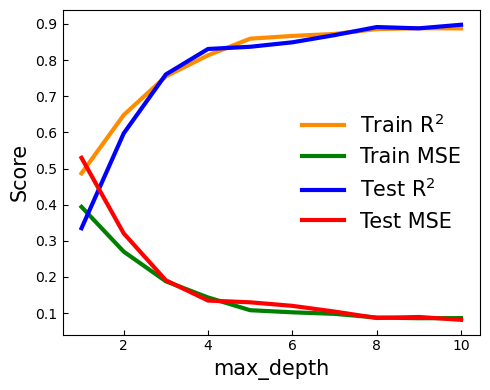

In [4]:
# plot r2 score and mse vs. max_depth
train_sc_all=[]
test_sc_all=[]
test_mse_all=[]
train_mse_all=[]
depth_range=range(1,11)
for i in depth_range:
    RFR = RandomForestRegressor(n_estimators=5, max_depth=i, min_samples_split=2, random_state=0)
    RFR.fit(X_train, y_train)
    y_predict = RFR.predict(X_test)
    y_predict_2 = RFR.predict(X_train)
    train_sc = RFR.score(X_train, y_train)
    test_sc = RFR.score(X_test, y_test)
    mse_test = mean_squared_error(y_test, y_predict)
    mse_train = mean_squared_error(y_train, y_predict_2)
    train_sc_all.append(train_sc)
    test_sc_all.append(test_sc)
    test_mse_all.append(mse_test)
    train_mse_all.append(mse_train)
plt.figure(figsize=(5,4))
plt.plot(depth_range, train_sc_all, lw=3, c='darkorange', label='Train R$^{2}$')
plt.plot(depth_range, train_mse_all, lw=3, c='green', label='Train MSE')
plt.plot(depth_range, test_sc_all, lw=3, c='blue', label='Test R$^{2}$')
plt.plot(depth_range, test_mse_all, lw=3, c='red', label='Test MSE')
plt.xlabel('max_depth', fontsize=15)
plt.ylabel('Score', fontsize=15)
plt.legend(loc='best', fontsize=15, frameon=False)
plt.tick_params(which='both', direction='in', labelsize=10)
plt.tight_layout()
plt.savefig('RFR Scores vs. max_depth.jpg', format='jpeg', dpi=600)
plt.show()

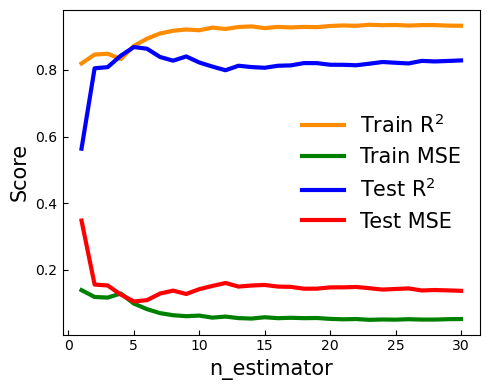

In [6]:
# plot r2 score and mse vs. n_estimator
train_sc_all=[]
test_sc_all=[]
test_mse_all=[]
train_mse_all=[]
estimator_range=range(1,31)
for i in estimator_range:
    RFR = RandomForestRegressor(n_estimators=i, max_depth=7, min_samples_split=2, random_state=0)
    RFR.fit(X_train, y_train)
    y_predict = RFR.predict(X_test)
    y_predict_2 = RFR.predict(X_train)
    train_sc = RFR.score(X_train, y_train)
    test_sc = RFR.score(X_test, y_test)
    mse_test = mean_squared_error(y_test, y_predict)
    mse_train = mean_squared_error(y_train, y_predict_2)
    train_sc_all.append(train_sc)
    test_sc_all.append(test_sc)
    test_mse_all.append(mse_test)
    train_mse_all.append(mse_train)
plt.figure(figsize=(5,4))
plt.plot(estimator_range, train_sc_all, lw=3, c='darkorange', label='Train R$^{2}$')
plt.plot(estimator_range, train_mse_all, lw=3, c='green', label='Train MSE')
plt.plot(estimator_range, test_sc_all, lw=3, c='blue', label='Test R$^{2}$')
plt.plot(estimator_range, test_mse_all, lw=3, c='red', label='Test MSE')
plt.xlabel('n_estimator', fontsize=15)
plt.ylabel('Score', fontsize=15)
plt.legend(loc='best', fontsize=15, frameon=False)
plt.tick_params(which='both', direction='in', labelsize=10)
plt.tight_layout()
plt.savefig('RFR Scores vs. n_estimator.jpg', format='jpeg', dpi=600)
plt.show()

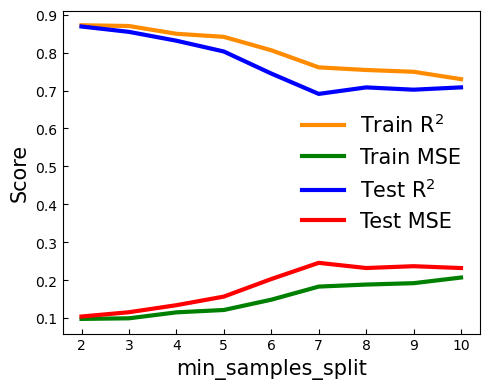

In [20]:
# plot r2 score and mse vs. min_samples_split
train_sc_all=[]
test_sc_all=[]
test_mse_all=[]
train_mse_all=[]
split_range=range(2,11)
for i in split_range:
    RFR = RandomForestRegressor(n_estimators=5, max_depth=7, min_samples_split=i, random_state=0)
    RFR.fit(X_train, y_train)
    y_predict = RFR.predict(X_test)
    y_predict_2 = RFR.predict(X_train)
    train_sc = RFR.score(X_train, y_train)
    test_sc = RFR.score(X_test, y_test)
    mse_test = mean_squared_error(y_test, y_predict)
    mse_train = mean_squared_error(y_train, y_predict_2)
    train_sc_all.append(train_sc)
    test_sc_all.append(test_sc)
    test_mse_all.append(mse_test)
    train_mse_all.append(mse_train)
plt.figure(figsize=(5,4))
plt.plot(split_range, train_sc_all, lw=3, c='darkorange', label='Train R$^{2}$')
plt.plot(split_range, train_mse_all, lw=3, c='green', label='Train MSE')
plt.plot(split_range, test_sc_all, lw=3, c='blue', label='Test R$^{2}$')
plt.plot(split_range, test_mse_all, lw=3, c='red', label='Test MSE')
plt.xlabel('min_samples_split', fontsize=15)
plt.ylabel('Score', fontsize=15)
plt.legend(loc='best', fontsize=15, frameon=False)
plt.tick_params(which='both', direction='in', labelsize=10)
plt.tight_layout()
plt.savefig('RFR Scores vs. min_samples_split.jpg', format='jpeg', dpi=600)
plt.show()

[0.8176032460597241, 0.8590784569088913, 0.8771479991271143, 0.8265084473973705, 0.8666460325146021, 0.8846875928706849, 0.832680456184676, 0.8721989992721448, 0.8939012142714109, 0.8493103688242221, 0.885510810083883, 0.8973280399805399]
[0.7899150913701684, 0.8366999561036318, 0.8342534297515491, 0.8186790950577832, 0.8490275062254202, 0.8468781199324587, 0.8427667618081176, 0.8688740331041471, 0.8638744818979613, 0.8719366623841109, 0.891190984725323, 0.8933707505138017]
[0.16724853168239653, 0.13000311513789653, 0.13195079402057672, 0.14434951711996968, 0.120189156245956, 0.1219002820182003, 0.12517333296698646, 0.10438934225117312, 0.10836948344150897, 0.10195118401552374, 0.08662282387242874, 0.0848875129930693]


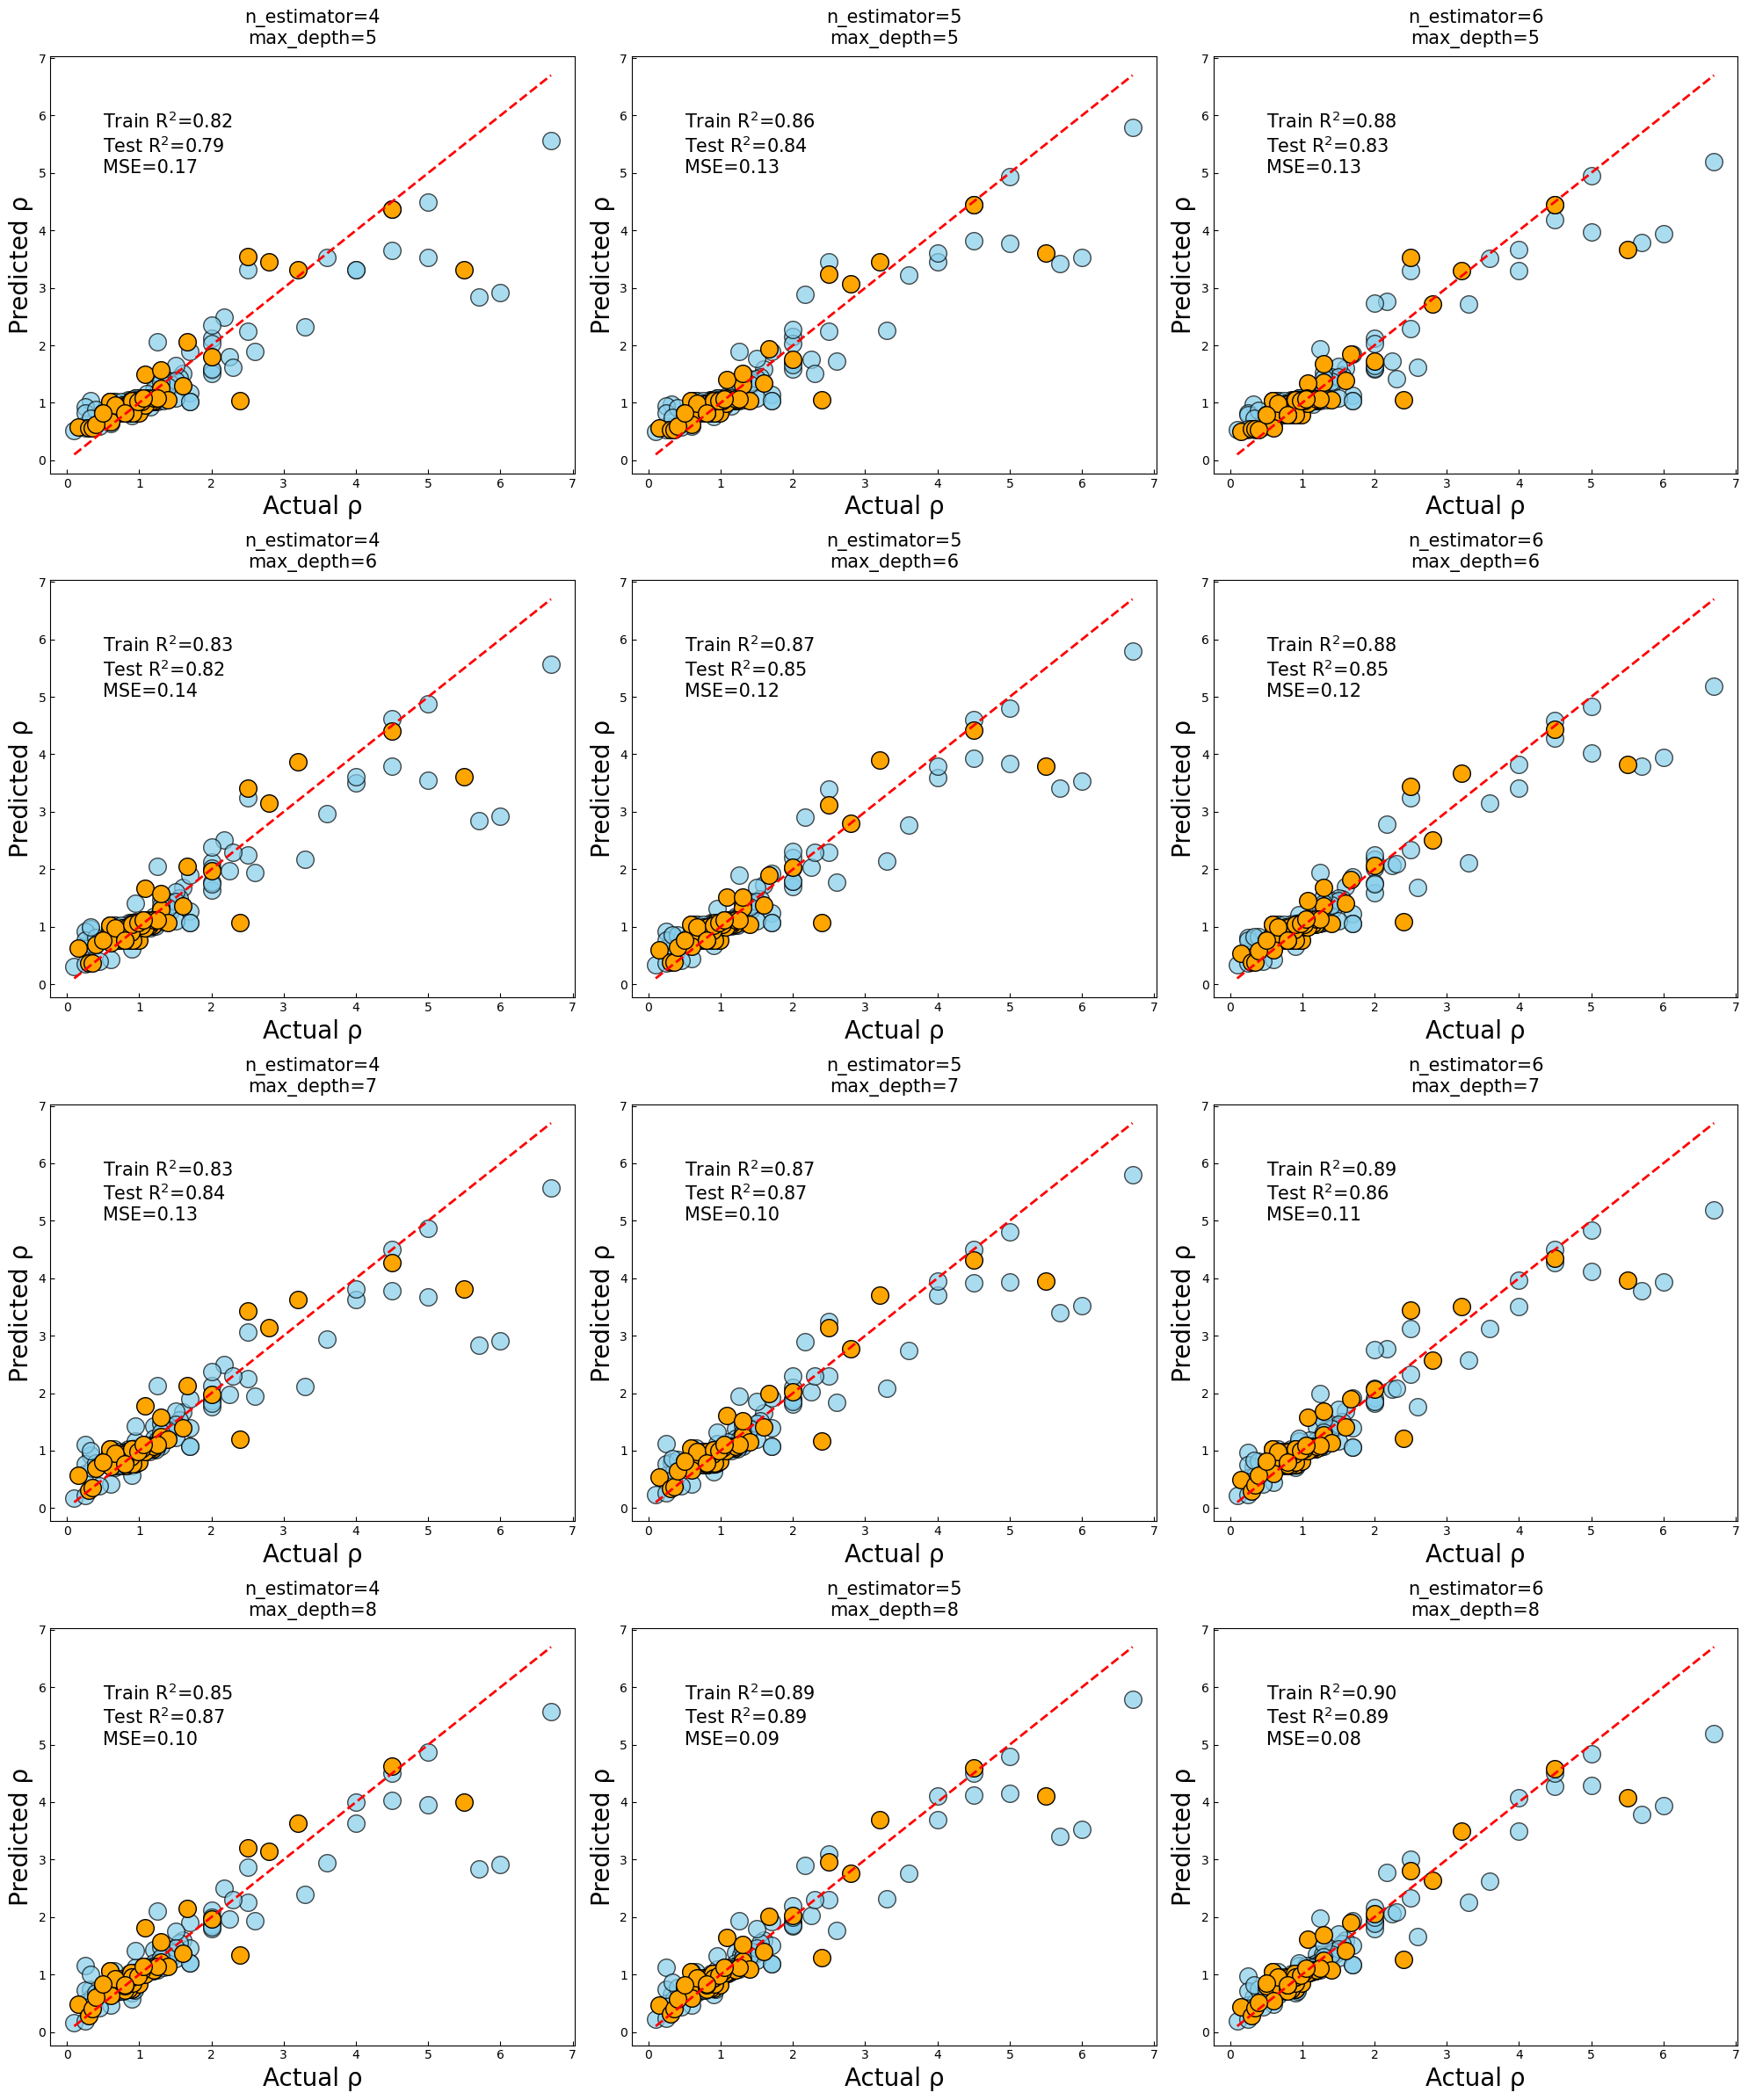

In [17]:
from sklearn.model_selection import cross_val_score

n = [4, 5, 6]
m = [5, 6, 7, 8]

fig, subaxes = plt.subplots(len(m), len(n), figsize=(len(m)*5, len(n)*8))

all_train_r2 = []
all_test_r2 = []
all_mse = []

for i, this_m in enumerate(m):
    for j, this_n in enumerate(n):
        RFR = RandomForestRegressor(n_estimators=this_n, max_depth=this_m, min_samples_split=2, random_state=0)
        RFR.fit(X_train, y_train)
        y_predict = RFR.predict(X_test)
        y_predict_2 = RFR.predict(X_train)

        subaxes[i, j].scatter(y_train, y_predict_2, s=200, alpha=0.7, edgecolors='black', c='skyblue')
        subaxes[i, j].scatter(y_test, y_predict, s=200, edgecolors='black', c='orange')
        subaxes[i, j].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
        subaxes[i, j].set_title(f'n_estimator={this_n}\nmax_depth={this_m}', pad=10, fontsize=15)
        subaxes[i, j].set_xlabel('Actual ρ', size=20)
        subaxes[i, j].set_ylabel('Predicted ρ', size=20)

        train_sc = RFR.score(X_train, y_train)
        test_sc = RFR.score(X_test, y_test)
        mse = mean_squared_error(y_test, y_predict)
        all_train_r2.append(train_sc)
        all_test_r2.append(test_sc)
        all_mse.append(mse)
        
        subaxes[i, j].text(0.5, 5, f'Train R$^{2}$={train_sc:.2f}\nTest R$^{2}$={test_sc:.2f}\nMSE={mse:.2f}',
                             fontsize=15)
        subaxes[i, j].tick_params(which='both', direction='in', labelsize=10)

print(all_train_r2)
print(all_test_r2)
print(all_mse)

plt.tight_layout()
#plt.savefig('RFR prediction matrix.jpg', format='jpeg', dpi=600)
plt.show()

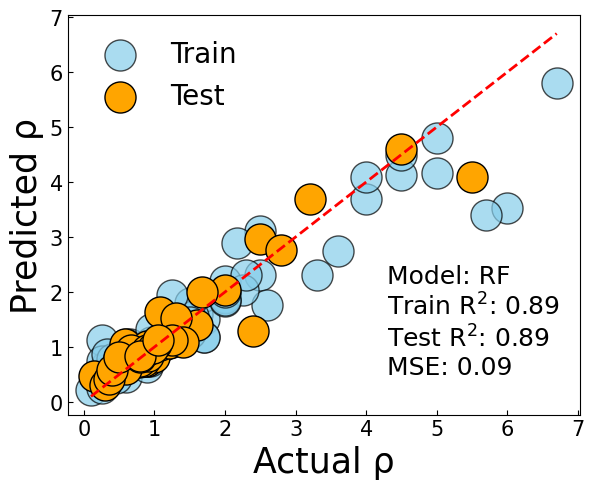

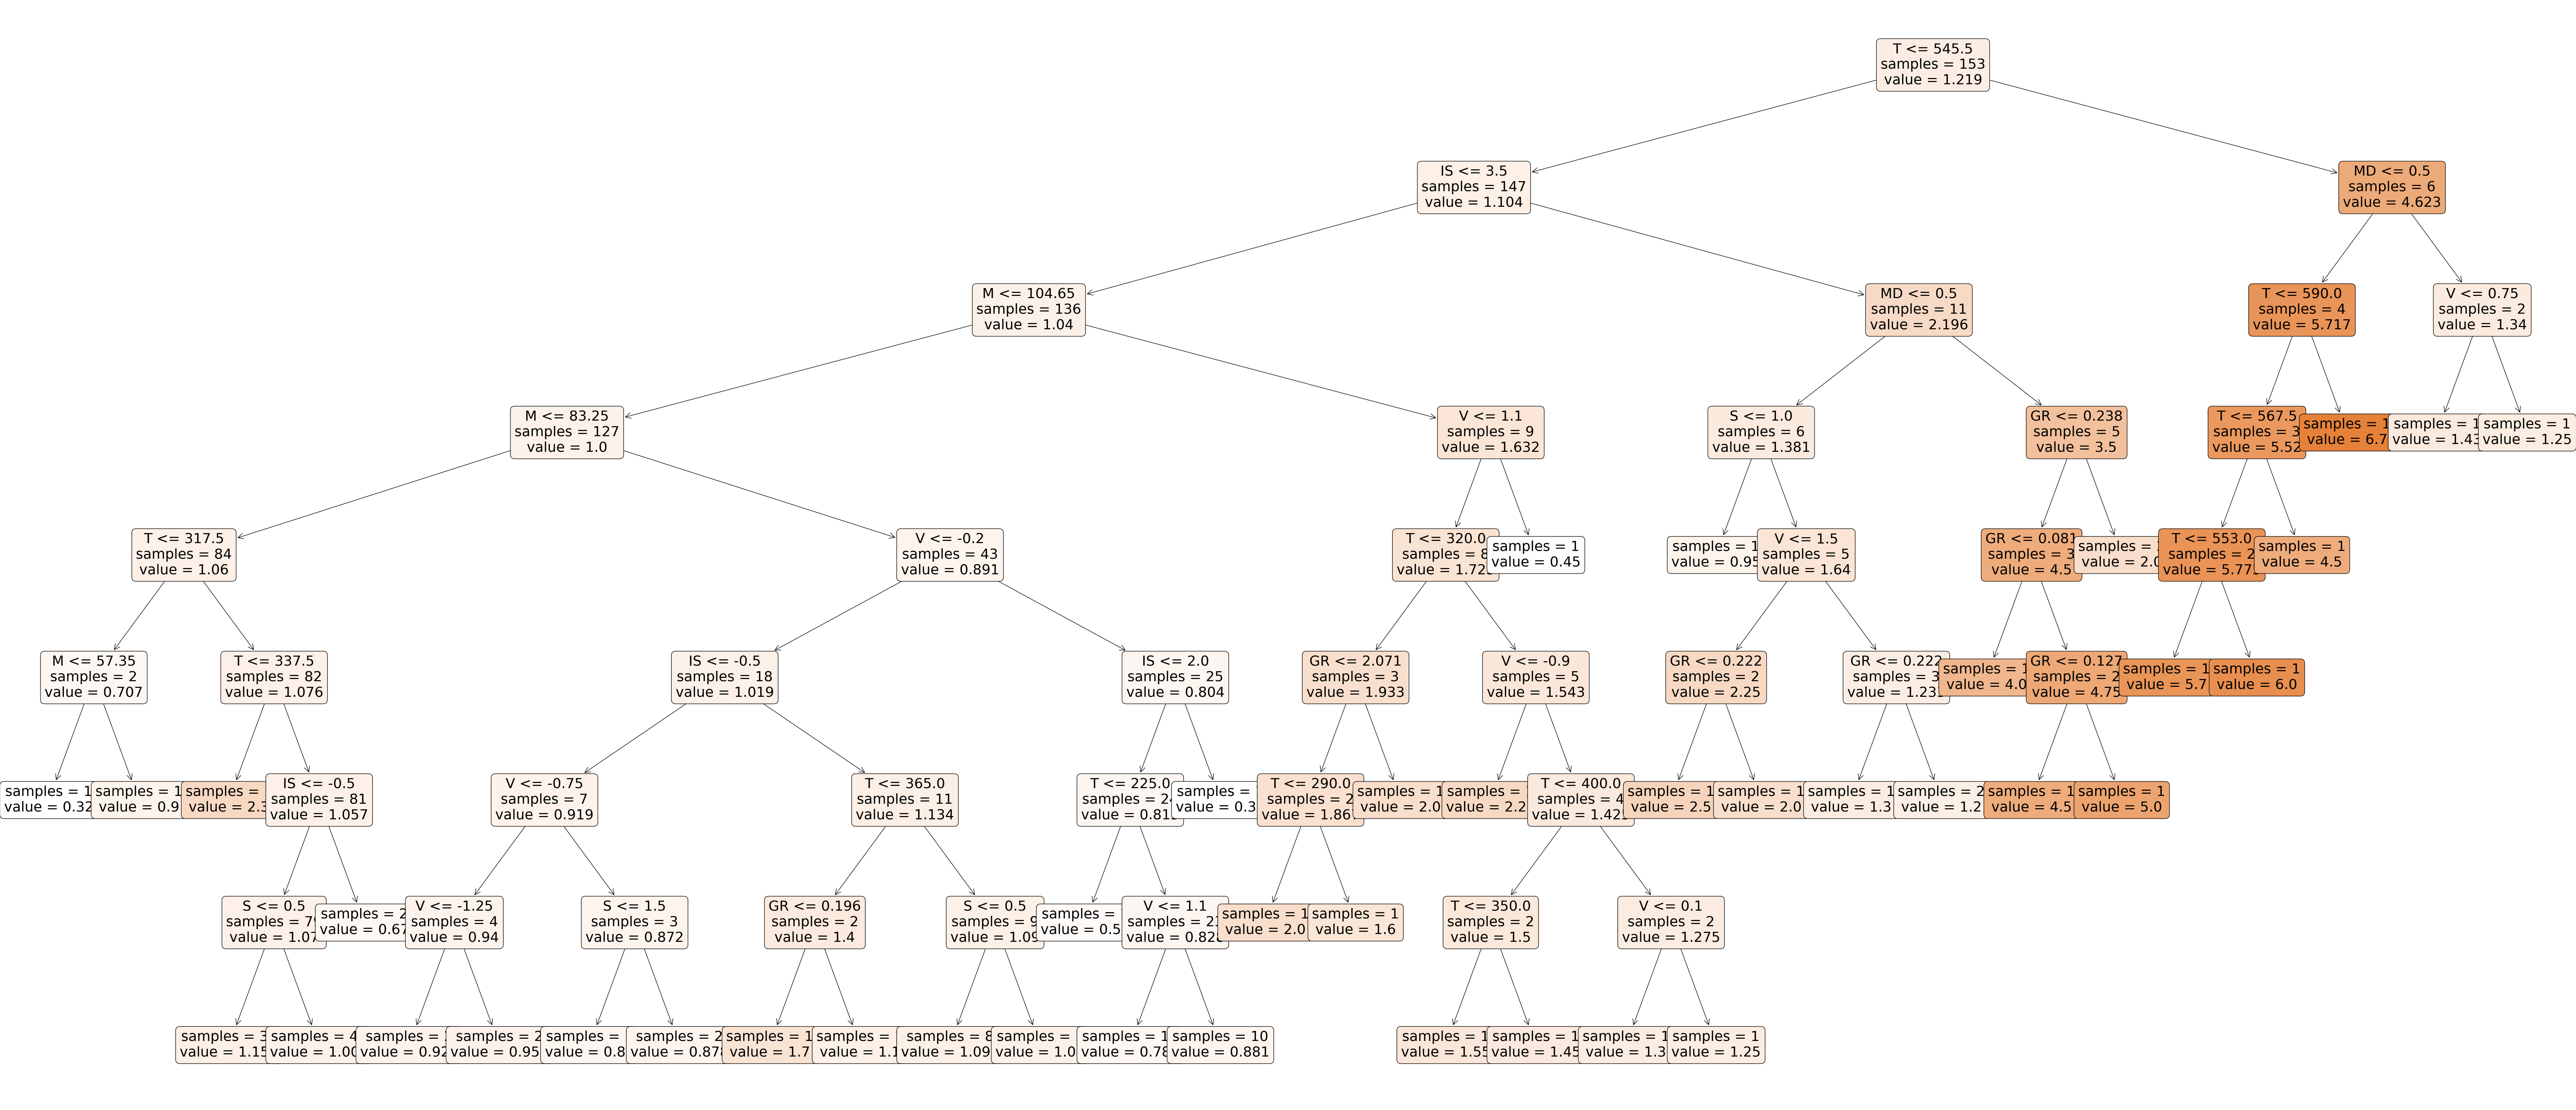

In [11]:
RFR_best = RandomForestRegressor(n_estimators=5, max_depth=8, min_samples_split=2, random_state=0)
RFR_best.fit(X_train, y_train)

y_predict = RFR_best.predict(X_test)
y_predict2 = RFR_best.predict(X_train)

train_score = RFR_best.score(X_train, y_train)
test_score = RFR_best.score(X_test, y_test)
mse = mean_squared_error(y_test, y_predict)

fig1 = plt.figure(figsize=(6,5))
plt.scatter(y_train, y_predict2, s=500, c='skyblue', alpha=0.7, label='Train', edgecolors='black')
plt.scatter(y_test, y_predict, s=500, c='orange', label='Test', edgecolors='black')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Actual ρ', size=25)
plt.ylabel('Predicted ρ', size=25)
plt.text(4.3, 0.5, f'Model: RF\nTrain R$^{2}$: {train_score:.2f}\nTest R$^{2}$: {test_score:.2f}\nMSE: {mse:.2f}', fontsize=18)
plt.legend(loc='best', fontsize=20, frameon=False)
plt.tick_params(which='both', direction='in', labelsize=15)
plt.tight_layout()
plt.savefig('RFR Actual vs. Predicted.jpg', format='jpeg', dpi=600)
plt.show()


# plot the tree structure
from sklearn.tree import plot_tree

tree = RFR_best.estimators_[4]
plt.figure(figsize=(70,30))
plot_tree(tree, feature_names=features, filled=True, rounded=True, impurity=False, fontsize=27)
plt.tight_layout()
plt.savefig('RFR_tree.jpg', format='jpeg', dpi=300)
plt.show()

Using 244 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/61 [00:00<?, ?it/s]

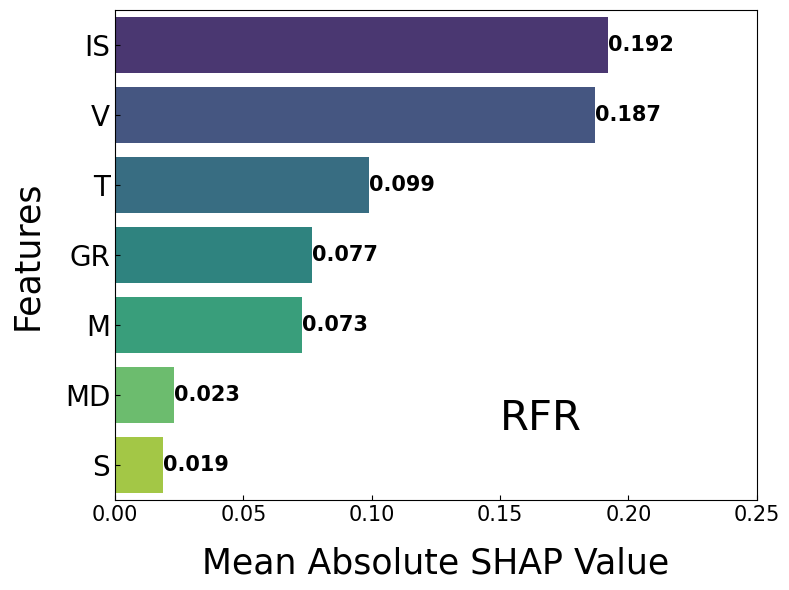

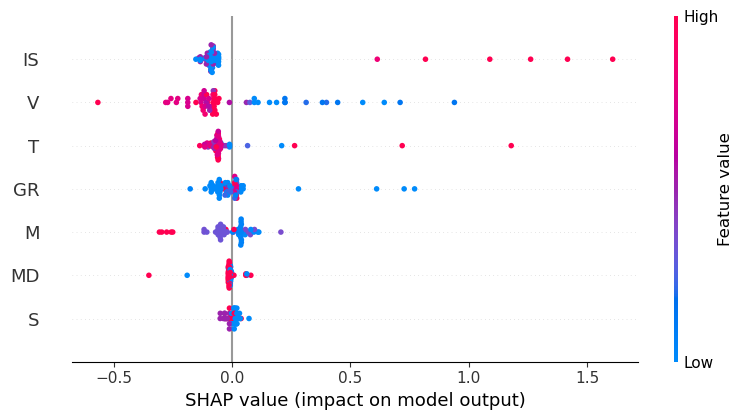

In [13]:
# determine the feature importance
# use SHAP to explain and visualize the feature importance
import shap
shap.initjs()
# Creating the KernelExplainer
RFR_explainer = shap.KernelExplainer(RFR_best.predict, X_train)
RFR_shap_values = RFR_explainer.shap_values(X_test)
# Generating the bar plot with mean SHAP values and feature names
# Calculate mean absolute SHAP values for each feature
mean_abs_shap_values = np.mean(np.abs(RFR_shap_values), axis=0)

# Create a DataFrame for plotting with SHAP values
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': mean_abs_shap_values})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
# Plotting the feature importances with values
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
# Adding the values on the bars
for index, value in enumerate(importance_df['Importance']):
    plt.text(value, index, f'{value:.3f}', va='center', ha='left', color='black', fontweight='bold', fontsize=15)

plt.xlim(0,0.25)
plt.xlabel('Mean Absolute SHAP Value', size=25, labelpad=15)
plt.ylabel('Features', size=25, labelpad=15)
plt.tick_params(axis='x', direction='in', labelsize=15)
plt.tick_params(axis='y', direction='in', labelsize=20)
plt.text(0.15, len(importance_df) - 1.5, 'RFR', fontsize=30)
plt.tight_layout()
plt.savefig('RFR Feature Importance.jpg', format='jpeg', dpi=600)
plt.show()
# Generating the summary plot showing the distribution of SHAP values for each feature
shap.summary_plot(RFR_shap_values, X_test, feature_names=X.columns)